## Imports

In [3]:
import pandas as pd
import numpy as np
import pickle
import dateutil.parser
import datetime
from datetime import datetime, date, timedelta
import time
import logging
from copy import deepcopy
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.chrome.options import Options
import requests
import re
import patsy
import os
import project_luther_functions as pf
import statsmodels.api as sm
import seaborn as sns
import copy
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing
%matplotlib inline

## Web Scraping

In [4]:
"""This section has been commented out, it was used to scrape weather data, but the scraping functions automatically pickle the files.
Header #3 starts the project off with a load of the pickle files created from similar scrape_data and scrape_conditions calls"""
# chromedriver = "/chromedriver_win32/"
# os.environ["webdriver.chrome.driver"] = chromedriver

# zipcode = '90012'
# Los Angeles
# earliest_date = 'Friday, January 1, 2010'

# chrome_options = Options()
# chrome_options.add_argument("-allow-running-insecure-content")
# driver = webdriver.Chrome('C:/Users/Paull/ds/metis/metisgh/chromedriver_win32/chromedriver', chrome_options=chrome_options)

# weather_df = pf.scrape_data(zipcode, earliest_date)

# hourly_condition_900120 = pf.scrape_conditions(zipcode, earliest_date)

'This section has been commented out, it was used to scrape weather data, but the scraping functions automatically pickle the files.\nHeader #3 starts the project off with a load of the pickle files created from similar scrape_data and scrape_conditions calls'

## Project Luther

In [ ]:
# Set Log File

In [5]:
logging.basicConfig(filename='project_luther.log',level=logging.DEBUG)

In [ ]:
# Load in scraped data

In [6]:
master_weather_dirty = pickle.load( open( "master_weather_dirty.p", "rb" ) )

In [7]:
condition_data = pickle.load( open("master_condition.p", "rb"))

In [ ]:
# Clean weather data and combine with daily condition value

In [8]:
weather_data = pf.clean_weather_data(master_weather_dirty)

In [9]:
condition_data['Date'] =condition_data['Date'].astype(str).apply(pf.parse_date)

In [10]:
master_weather = pf.get_day_cond(weather_data, condition_data)

In [ ]:
 # Pull in Air Quality Index data and merge target (arithmetic mean) with master weather df on date

In [11]:
aqi_2005 = pf.aqi_data(2005)

C:\Users\Paull\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [12]:
ozone_data = aqi_2005.query('Observation_Percent == 100.0')[['Date','Arithmetic_Mean']]

In [13]:
cleaned_weather = pd.merge(master_weather, ozone_data, on='Date', how='right')

In [ ]:
# First pass of dropping non-included columns, added cleaning, determine length of day and drop other columns from later passes

In [14]:
model_parameters = cleaned_weather.drop(['Since_1_July_precipitation', 'Month_to_date_cooling_degree_days', 'Since_1_July_heating_degree_days',
                                   'Since_1_June_cooling_degree_days', 'Month_to_date_heating_degree_days', 'Since_1_June_heating_degree_days',
                                   'Month_to_date_precipitation', 'Year_to_date_cooling_degree_days', 'Year_to_date_precipitation',
                                   'Events','Snow','Month_to_date_snowfall', 'Date','Snow_Depth','Since_1_July_snowfall','Zipcode'],1)

In [16]:
model_parameters['Total_daylight'] = model_parameters['Sunset'].apply(pf.to_datetime) - model_parameters['Sunrise'].apply(pf.to_datetime)

In [17]:
model_parameters = model_parameters.drop(['Sunset', 'Sunrise'],1)

In [19]:
model_parameters['Moon_Phase'] = model_parameters['Moon_Phase'].apply(pf.clean_moon_phase);

In [20]:
model_parameters = model_parameters.drop('Wind_Dir', axis=1)

In [21]:
model_parameters = model_parameters.drop('Moon_Phase',axis =1)

In [23]:
model_parameters.shape

(3118, 18)

In [34]:
model_parameters['Total_daylight'] = model_parameters['Total_daylight'].apply(pf.fract_hour)

In [ ]:
# Check to see that all columns contain numeric values

In [35]:
model_parameters.dtypes

Arithmetic_Mean       float64
Average_Humidity      float64
Dew_Point             float64
Max_Gust_Speed        float64
Min_Temperature       float64
Precipitation         float64
Sea_Level_Pressure    float64
Day_Cond              float64
Total_daylight        float64
dtype: object

In [27]:
model_parameters = model_parameters[['Arithmetic_Mean','Average_Humidity','Dew_Point','Max_Gust_Speed','Min_Temperature','Precipitation','Sea_Level_Pressure','Day_Cond','Total_daylight']]
X_vals = model_parameters.columns
X_vals

Index(['Arithmetic_Mean', 'Average_Humidity', 'Dew_Point', 'Max_Gust_Speed',
       'Min_Temperature', 'Precipitation', 'Sea_Level_Pressure', 'Day_Cond',
       'Total_daylight'],
      dtype='object')

In [37]:
model_parameters = model_parameters.dropna()

In [38]:
X_vals_phrase = ''
X_vals_phrase = X_vals[1]
for x in X_vals[2:]:
    X_vals_phrase += " + " + x
print(X_vals_phrase)

Average_Humidity + Dew_Point + Max_Gust_Speed + Min_Temperature + Precipitation + Sea_Level_Pressure + Day_Cond + Total_daylight


In [39]:
y, X = patsy.dmatrices('Arithmetic_Mean ~ %s' % X_vals_phrase, data=model_parameters, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Arithmetic_Mean   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     459.5
Date:                Fri, 28 Apr 2017   Prob (F-statistic):               0.00
Time:                        14:54:37   Log-Likelihood:                 11298.
No. Observations:                3118   AIC:                        -2.258e+04
Df Residuals:                    3109   BIC:                        -2.252e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              0.3805      0.047      8.180      0.000         0.289     0.472
Average_Humidity    9.799e-05   2.62e-05      3.735      0.000      4.66e-05     0.000
Dew_Point             -0.0002   4.54e-05     -4.503      0.000        -0.000    -0.000
Max_Gust_Speed         0.0005   3.52e-05     14.078      0.000         0.000     0.001
Min_Temperature        0.0002   4.51e-05      5.400      0.000         0.000     0.000
Precipitation         -0.0050      0.001     -6.932      0.000        -0.006    -0.004
Sea_Level_Pressure    -0.0138      0.002     -9.052      0.000        -0.017    -0.011
Day_Cond              -0.0038      0.001     -6.565      0.000        -0.005    -0.003
Total_daylight         0.0032      0.000     29.344      0.000         0.003     0.003
==============================================================================
Omnibus:                      118.540   Durbin-Watson:                   0.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.737
Skew:                           0.425   Prob(JB):                     2.26e-32
Kurtosis:                       3.632   Cond. No.                     4.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
model_parameters.corr()

,Arithmetic_Mean,Average_Humidity,Dew_Point,Max_Gust_Speed,Min_Temperature,Precipitation,Sea_Level_Pressure,Day_Cond,Total_daylight
Arithmetic_Mean,1.000000,0.242725,0.421693,0.362142,0.471916,-0.061405,-0.501943,-0.146934,0.679457
Average_Humidity,0.242725,1.000000,0.735513,0.059740,0.195196,0.234452,-0.270672,-0.515528,0.289932
Dew_Point,0.421693,0.735513,1.000000,0.001484,0.747915,0.030947,-0.590663,-0.218176,0.575083
Max_Gust_Speed,0.362142,0.059740,0.001484,1.000000,0.018663,0.241966,-0.234701,-0.135793,0.251962
Min_Temperature,0.471916,0.195196,0.747915,0.018663,1.000000,-0.107525,-0.658436,0.006680,0.612523
Precipitation,-0.061405,0.234452,0.030947,0.241966,-0.107525,1.000000,-0.085178,-0.365481,-0.136845
Sea_Level_Pressure,-0.501943,-0.270672,-0.590663,-0.234701,-0.658436,-0.085178,1.000000,0.109495,-0.527914
Day_Cond,-0.146934,-0.515528,-0.218176,-0.135793,0.006680,-0.365481,0.109495,1.000000,-0.025129
Total_daylight,0.679457,0.289932,0.575083,0.251962,0.612523,-0.136845,-0.527914,-0.025129,1.000000


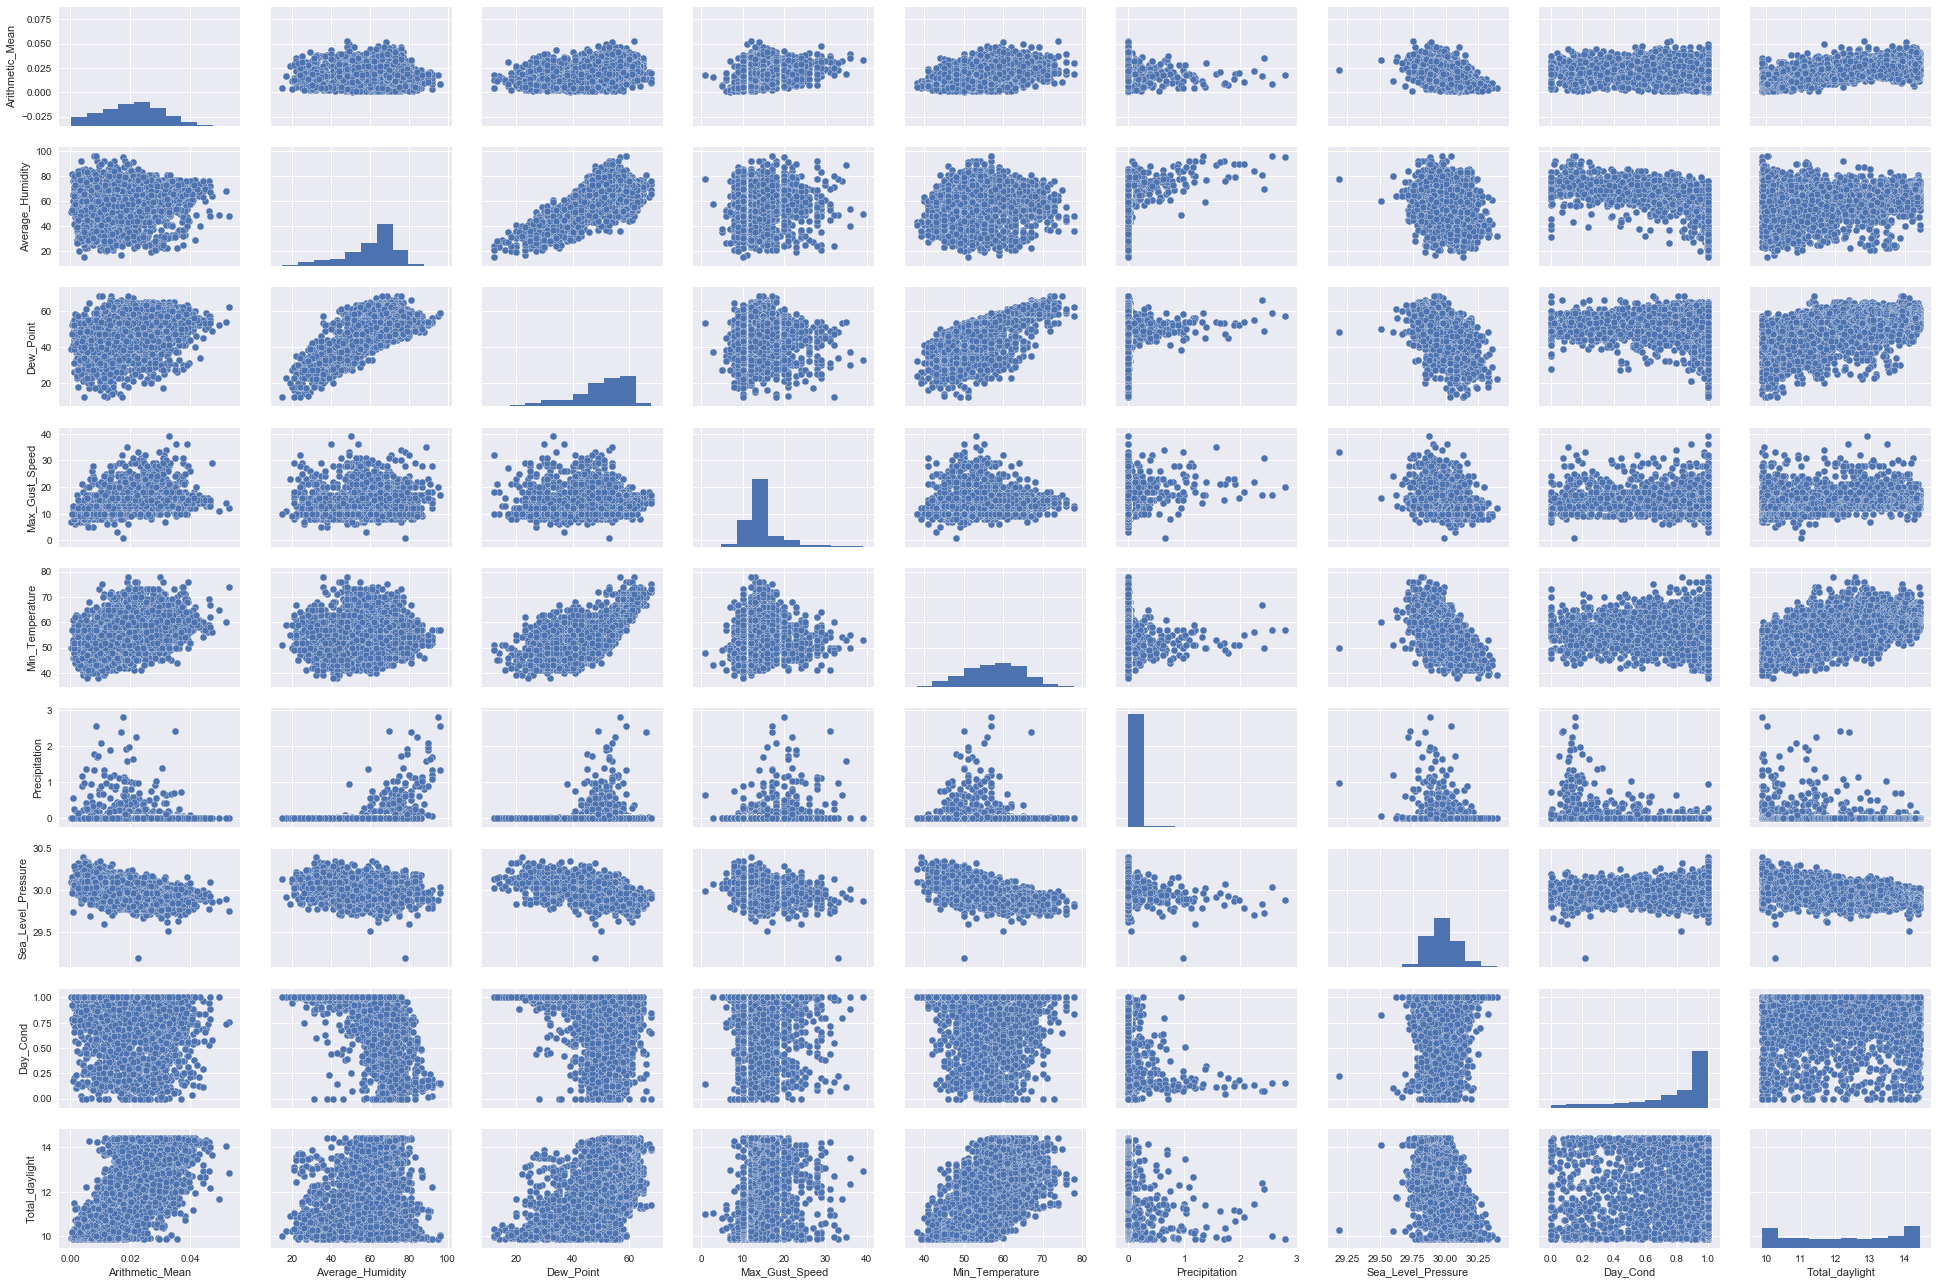

In [41]:
sns.pairplot(model_parameters, size = 2, aspect=1.5);

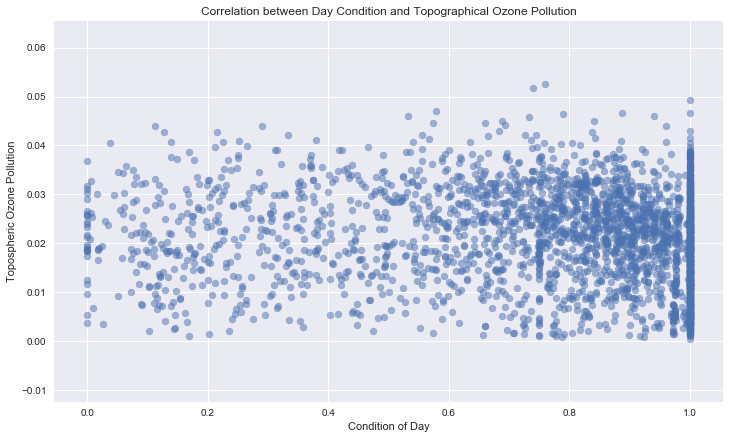

In [44]:
plt.figure(figsize=(12,7))
plt.title("Correlation between Day Condition and Topographical Ozone Pollution")
plt.xlabel('Condition of Day')
plt.ylabel('Topospheric Ozone Pollution')
plt.scatter(model_parameters['Day_Cond'],model_parameters['Arithmetic_Mean'],alpha=.5);

In [45]:
rcv = RidgeCV(cv=10, alphas=[10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1], scoring='r2')
preprocessing.normalize(X)
fitrcv = rcv.fit(X,y)
fitrcv.score(X,y)

0.54175836662072885

In [46]:
rcv.alpha_

1e-05

In [47]:
y_hat = fitrcv.predict(X)
residuals = y_hat - y

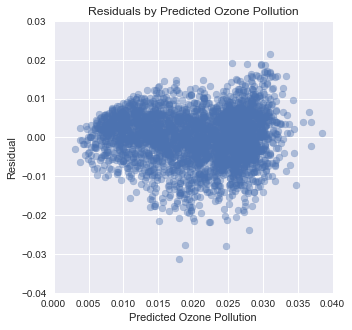

In [48]:
sns.set(font_scale=2)
plt.figure(figsize=(5,5))
plt.style.use('seaborn')
plt.title('Residuals by Predicted Ozone Pollution')
plt.xlabel('Predicted Ozone Pollution')
plt.ylabel('Residual')
plt.axis([0, 0.04, -0.04, 0.03])
plt.scatter(y_hat, residuals, alpha=0.4)
plt.show();


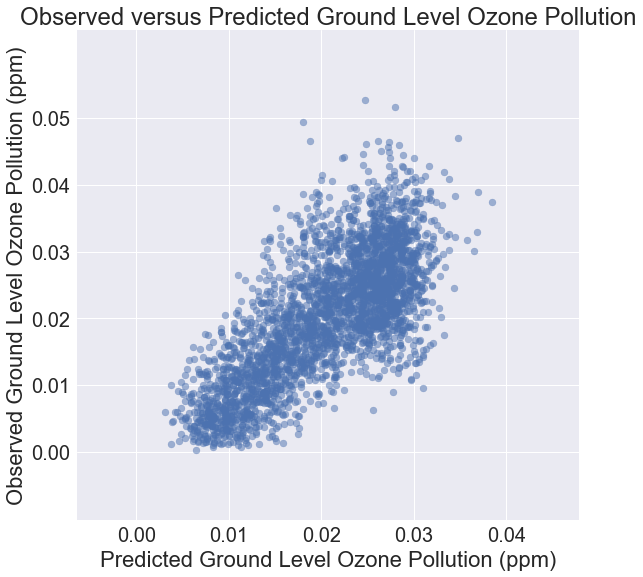

In [49]:
sns.set(font_scale=2)
plt.figure(figsize=(9,9))
plt.xticks([0,0.01,0.02,0.03,0.04,0.05])
plt.yticks([0,0.01,0.02,0.03,0.04,0.05])
plt.title("Observed versus Predicted Ground Level Ozone Pollution")
sns.set(font_scale=.5)
plt.xlabel("Predicted Ground Level Ozone Pollution (ppm)")
plt.ylabel("Observed Ground Level Ozone Pollution (ppm)")
plt.scatter(y_hat,y,alpha=.5);